In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import json
import pandas as pd
import os

from config.config import Config
from utils.metrics import decode_rle_to_mask

In [2]:
config = Config('config.yaml')

In [ ]:
####################################################################
# validation dataset -> mode = 'train'
# test dataset -> mode = 'test'
mode = 'test'
####################################################################

if mode == 'train':
    df = pd.read_csv(os.path.join(config.TRAIN.OUTPUT_DIR, config.TRAIN.CSV_NAME))
else:  # mode가 'test'일 때
    df = pd.read_csv(os.path.join(config.INFERENCE.OUTPUT_DIR, config.INFERENCE.CSV_NAME))

IMG_ROOT = config.DATA.IMAGE_ROOT if mode=='train' else config.DATA.TEST_IMAGE_ROOT  # 이미지 루트 경로 설정 

# IND2IMG 딕셔너리 생성
ID2IMG = {}

# df['image_name']에 있는 파일명만 필터링하기 위해 집합으로 변환
valid_images = set(df['image_name'])

# IMG_ROOT 경로 내 하위폴더 중 df에 저장된 파일만 딕셔너리 저장
for folder_name in os.listdir(IMG_ROOT):
    folder_path = os.path.join(IMG_ROOT, folder_name)
    # 폴더인 경우에만 처리
    if os.path.isdir(folder_path):
        # 유효한 이미지 파일만 추가
        for image_name in os.listdir(folder_path):
            if image_name in valid_images:  # image_name이 df['image_name']에 존재하는 경우만 추가
                if folder_name not in ID2IMG:
                    ID2IMG[folder_name] = []
                ID2IMG[folder_name].append(image_name)
                    

In [5]:
CLASS2IND = {v: i for i, v in enumerate(config.DATA.CLASSES)}
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

# 시각화를 위한 팔레트를 설정합니다.
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# 시각화 함수입니다. 클래스가 2개 이상인 픽셀을 고려하지는 않습니다.
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image


# GT 마스크 생성 함수
def create_gt_mask(label_path, image_shape):
    # GT 마스크의 shape 생성 (높이, 너비, 클래스 수)
    label_shape = (image_shape[0], image_shape[1], len(config.DATA.CLASSES))
    label = np.zeros(label_shape, dtype=np.uint8)
    
    # JSON 레이블 파일 열기
    with open(label_path, "r") as f:
        annotations = json.load(f)
    annotations = annotations["annotations"]
    
    # 클래스별로 마스크 생성
    for ann in annotations:
        c = ann["label"]
        class_ind = CLASS2IND[c]
        points = np.array(ann["points"])
        
        # 각 클래스 마스크 생성 및 할당
        class_label = np.zeros(image_shape[:2], dtype=np.uint8)
        cv2.fillPoly(class_label, [points], 1)
        label[..., class_ind] = class_label
    
    # 채널 순서 변경 (H, W, C) -> (C, H, W)
    label = label.transpose(2, 0, 1)
    
    return label

In [ ]:
# 시각화 함수
def visualize_segmentation(df, visualize_ind, mode=mode, image_root=IMG_ROOT, image_size=(2048, 2048)):
    
    ncols = 3 if mode == 'train' else 2
    for id in visualize_ind:
        image_filenames = ID2IMG[id]
        
        # 이미지 파일 개수 확인
        if len(image_filenames) != 2:
            print(f"Expected 2 unique images in folder {id}, found {len(image_filenames)}.")
            return       
        
        # 시각화 설정
        fig, axes = plt.subplots(2, ncols, figsize=(6 * ncols, 12))
        fig.suptitle(f"Visualizations for images in folder: {id}")
        
        for row, image_filename in enumerate(image_filenames):
            image_path = os.path.join(image_root, id, image_filename)
            
            # 이미지 경로 확인
            if not os.path.exists(image_path):
                print(f"Image path {image_path} does not exist.")
                continue
            
            # 원본 이미지 로드
            original_image = cv2.imread(image_path)
            if original_image is None:
                print(f"Failed to load image {image_filename} at path {image_path}.")
                continue
            
            # RLE 마스크 디코딩
            preds = []
            filtered_df = df[df['image_name'] == image_filename]
            for _, row_data in filtered_df.iterrows():
                if pd.notna(row_data['rle']):
                    pred = decode_rle_to_mask(row_data['rle'], height=image_size[0], width=image_size[1])
                    preds.append(pred)
            preds = np.stack(preds, axis=0)
            
            # 원본 이미지 시각화
            axes[row, 0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
            axes[row, 0].set_title(f'Original Image: {image_filename}')
            
            # GT (학습모드일 때만 plot)
            if mode == 'train':
                label_root = config.DATA.LABEL_ROOT
                label_filename = image_filename.split('.')[0] + '.json'
                label_path = os.path.join(label_root, id, label_filename)
                gt_mask = create_gt_mask(label_path, original_image.shape)
                    
                axes[row, 1].imshow(label2rgb(gt_mask))
                axes[row, 1].set_title('Ground Truth')

            # 예측 마스크를 불투명하게 겹쳐서 표시
            prediction_overlay = label2rgb(preds)
            overlay_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB).copy()
            mask = np.any(prediction_overlay != [0, 0, 0], axis=-1)
            overlay_image[mask] = prediction_overlay[mask]
            
            axes[row, ncols - 1].imshow(overlay_image)
            axes[row, ncols - 1].set_title(f'Predicted Mask Overlay for {image_filename}')
            
            # 축 숨기기
            for ax in axes[row, :]:
                ax.axis("off")

        plt.tight_layout()
        plt.show()

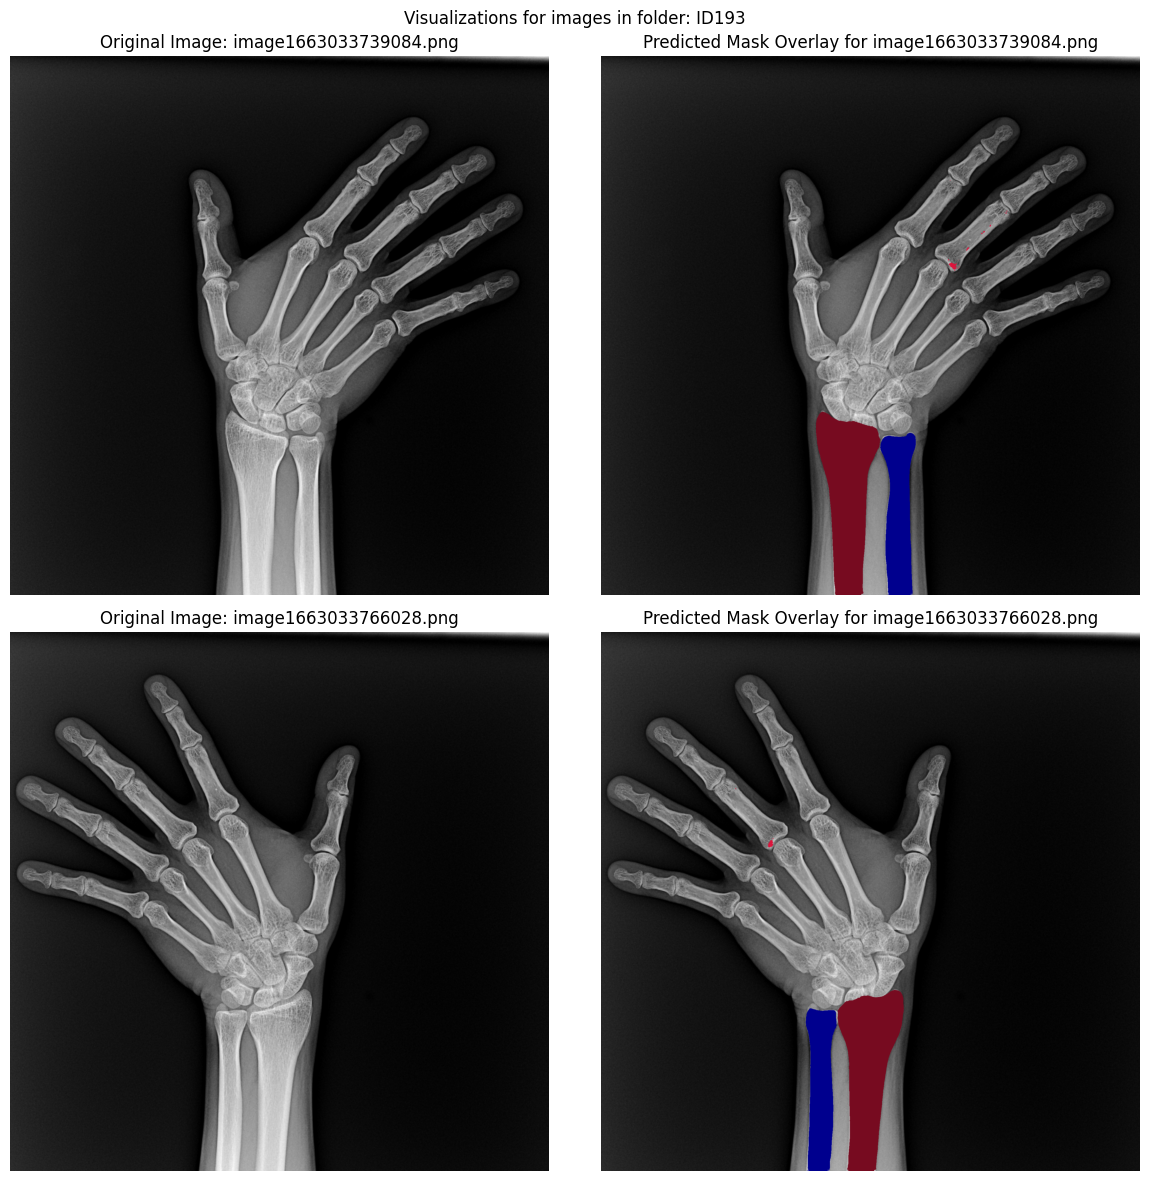

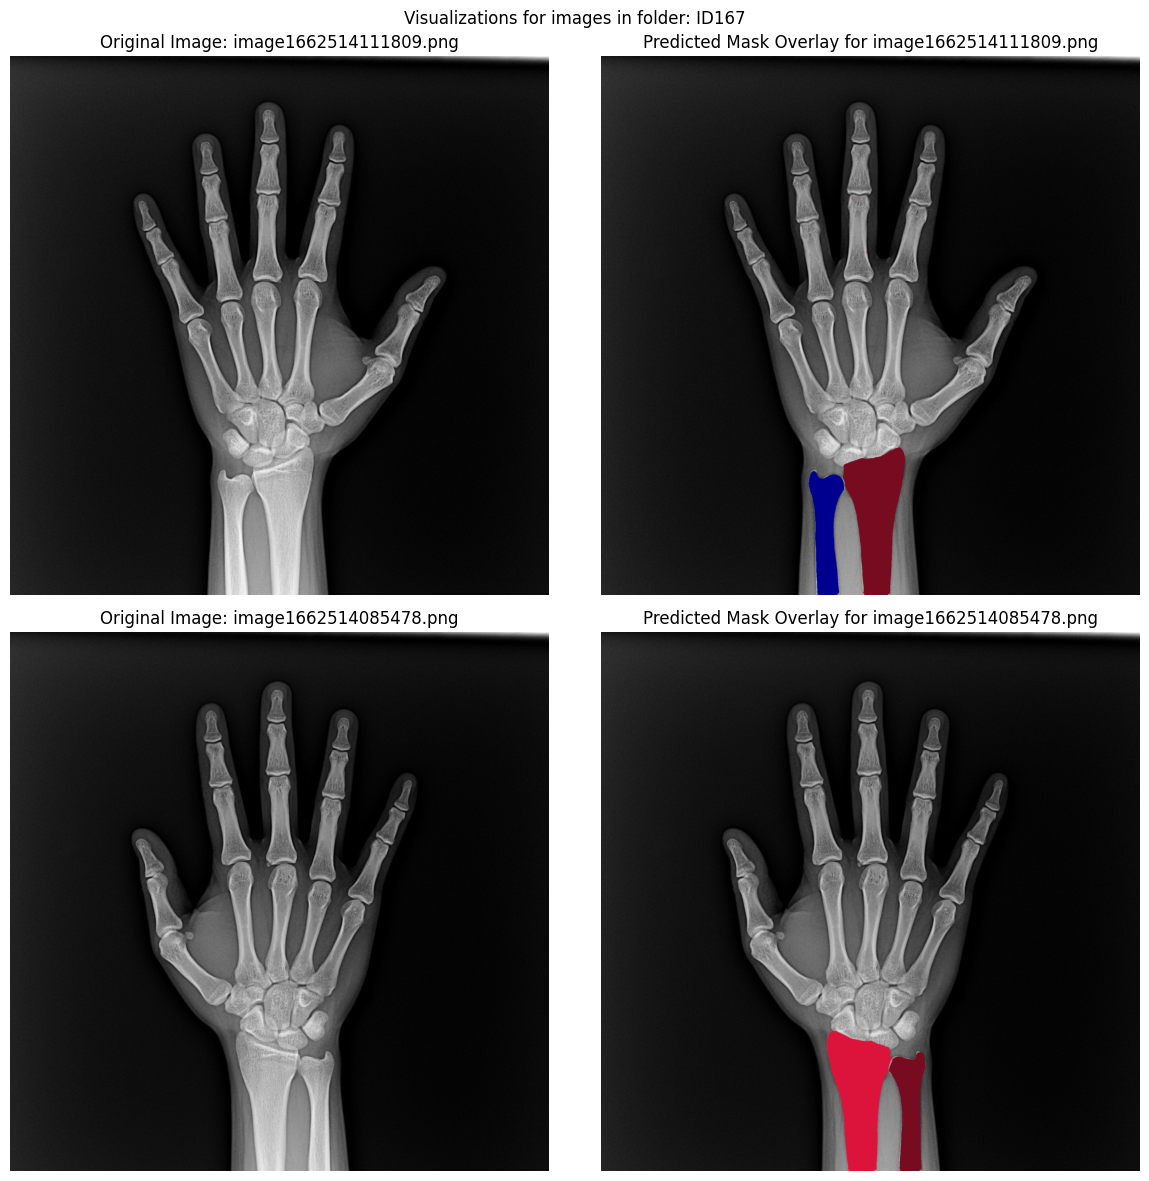

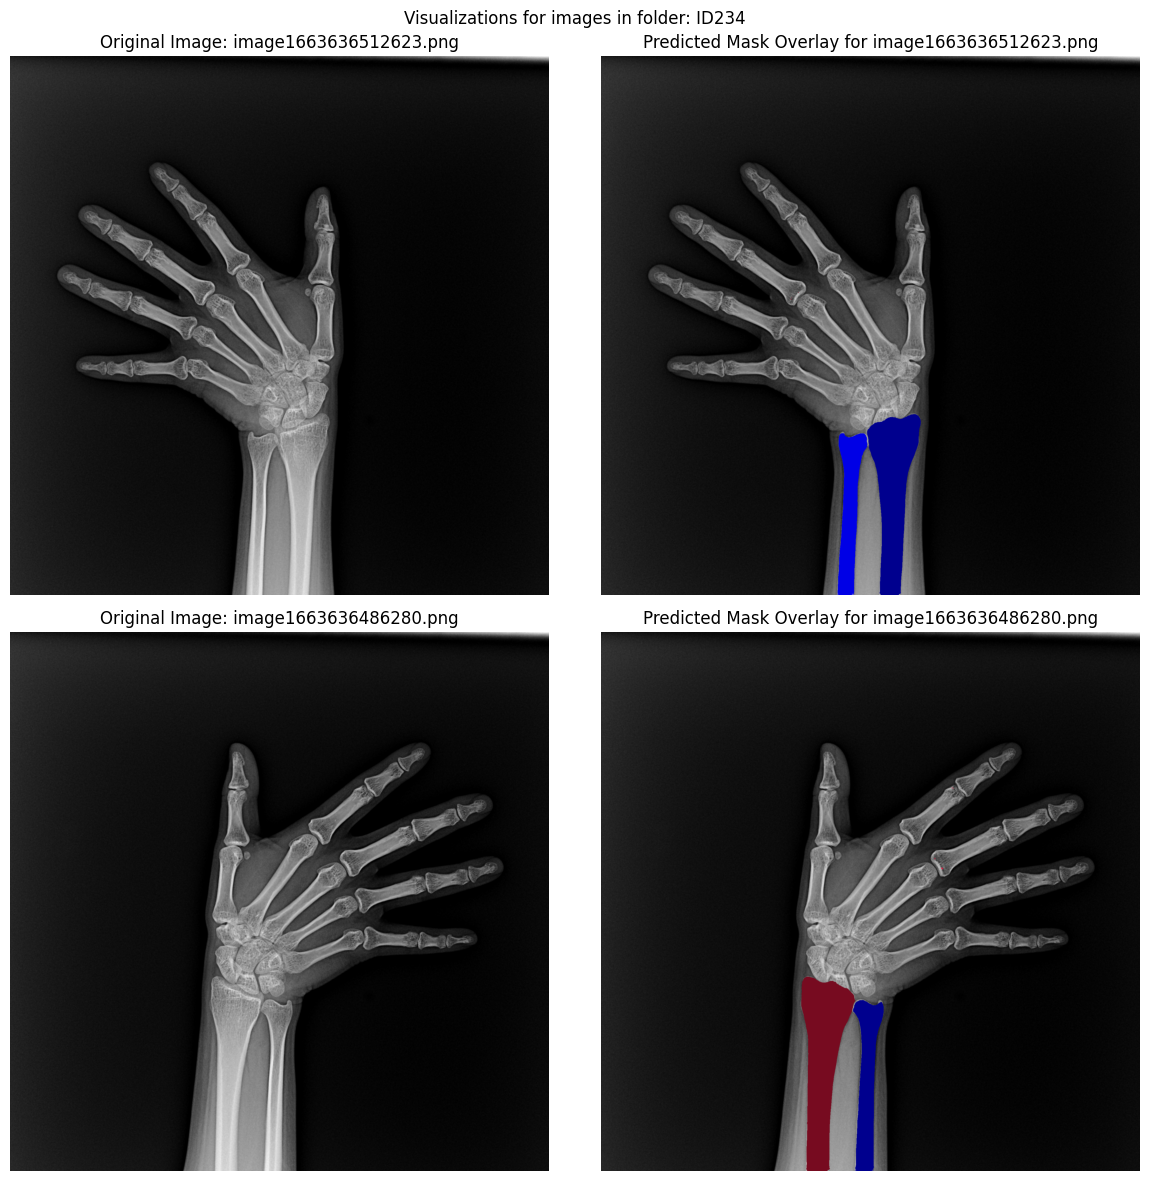

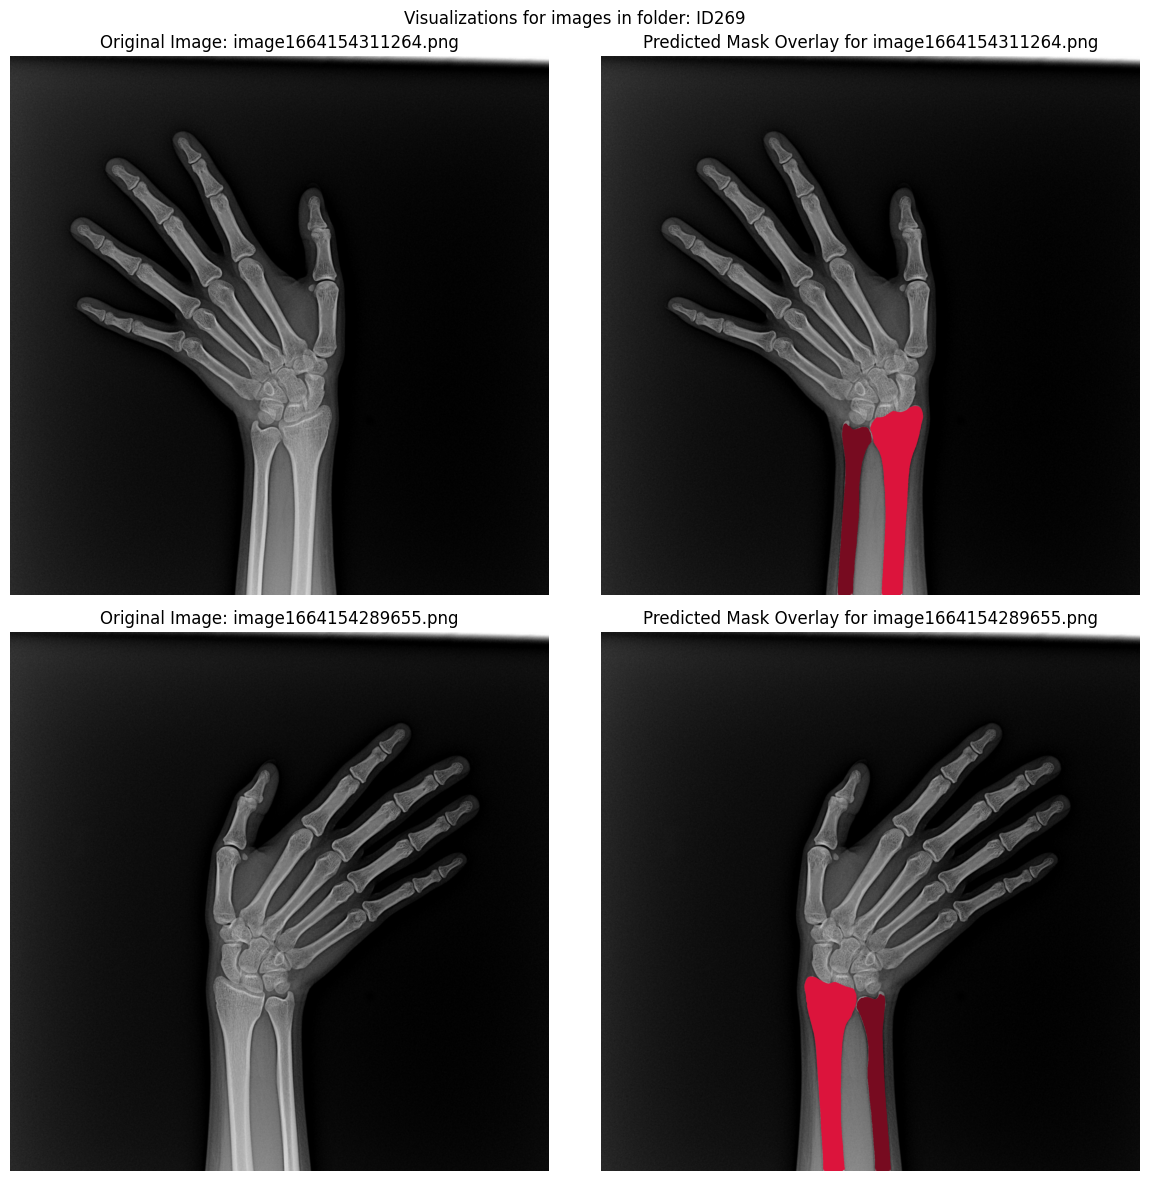

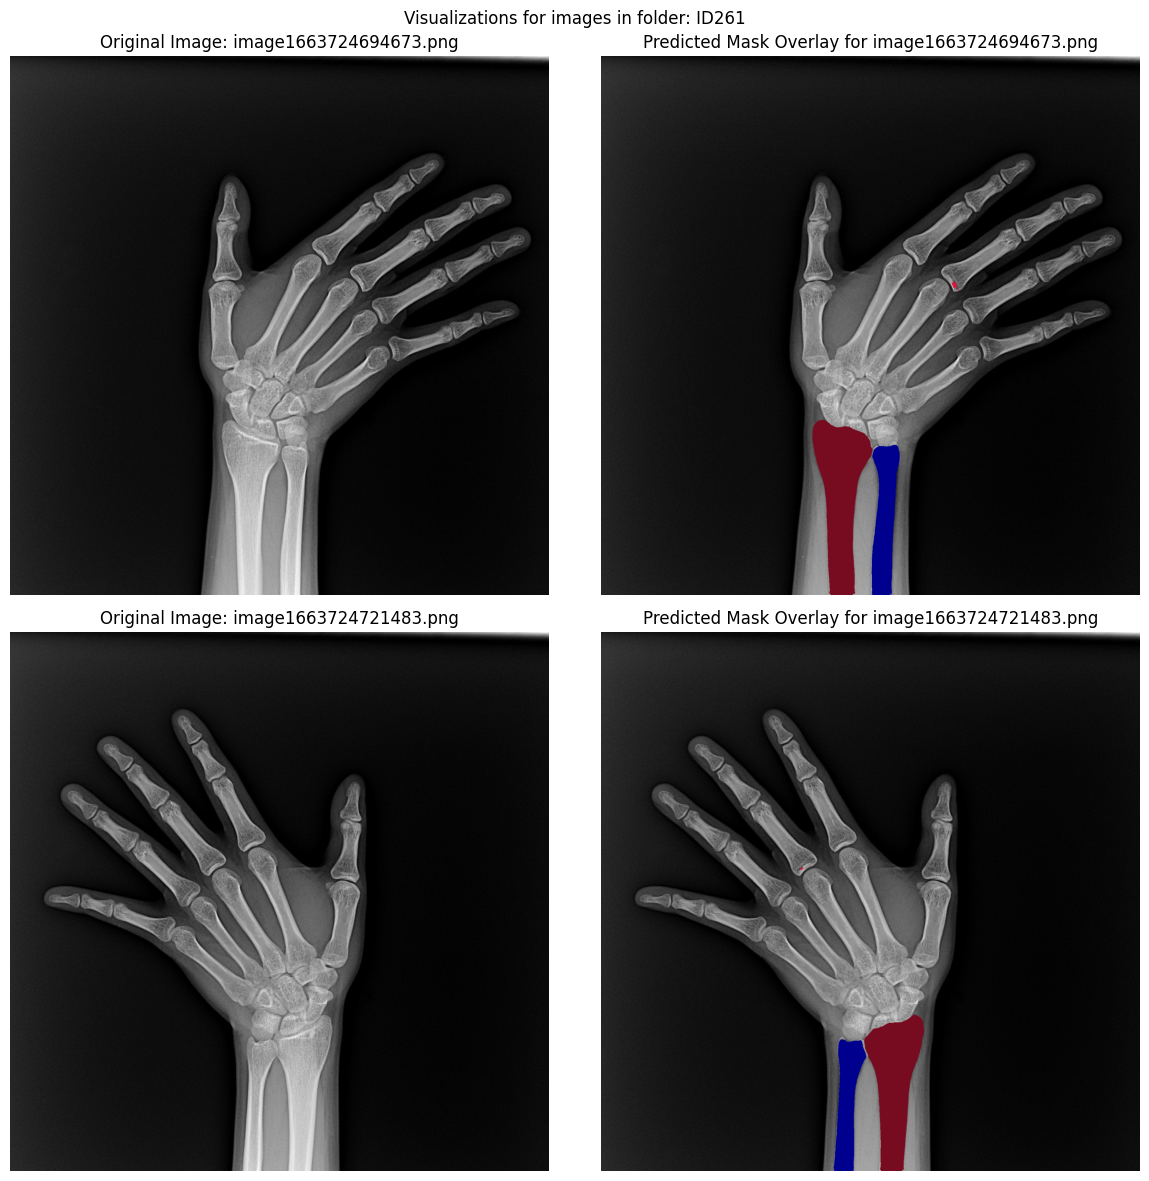

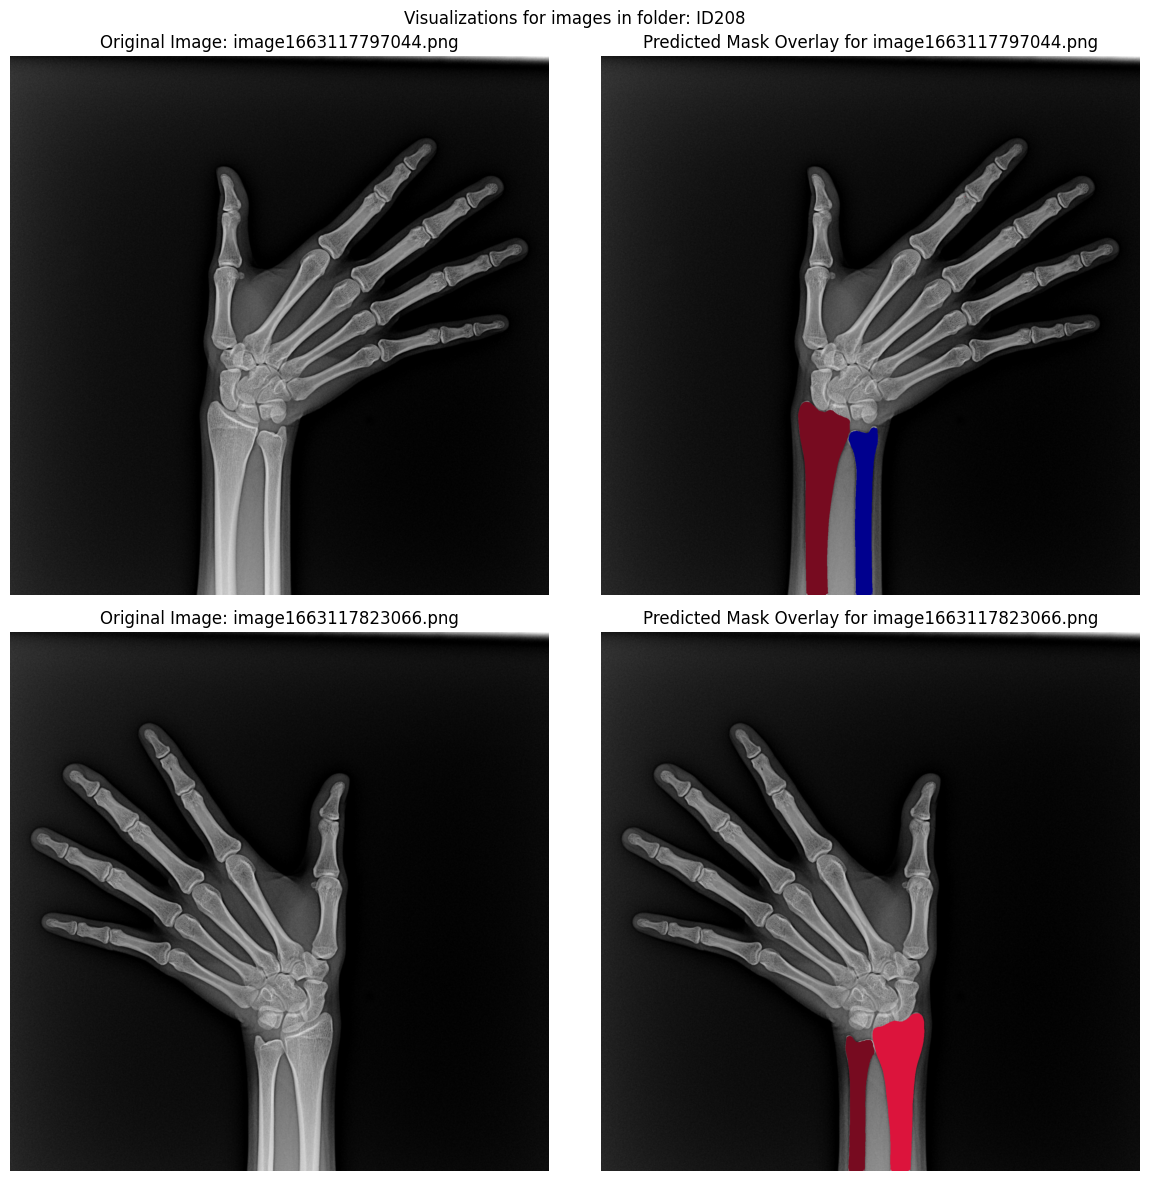

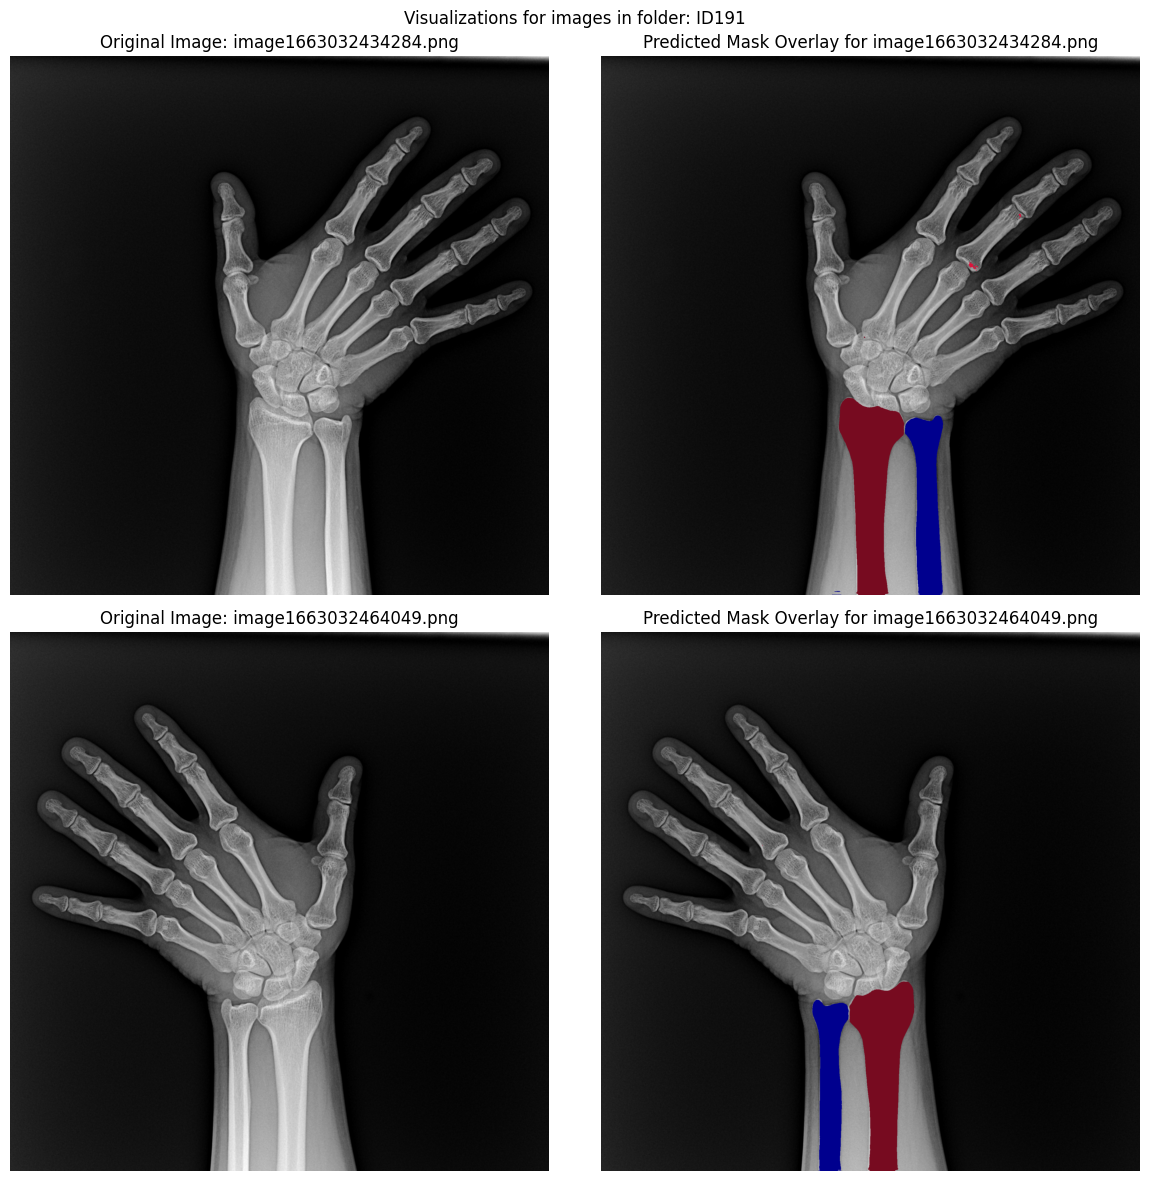

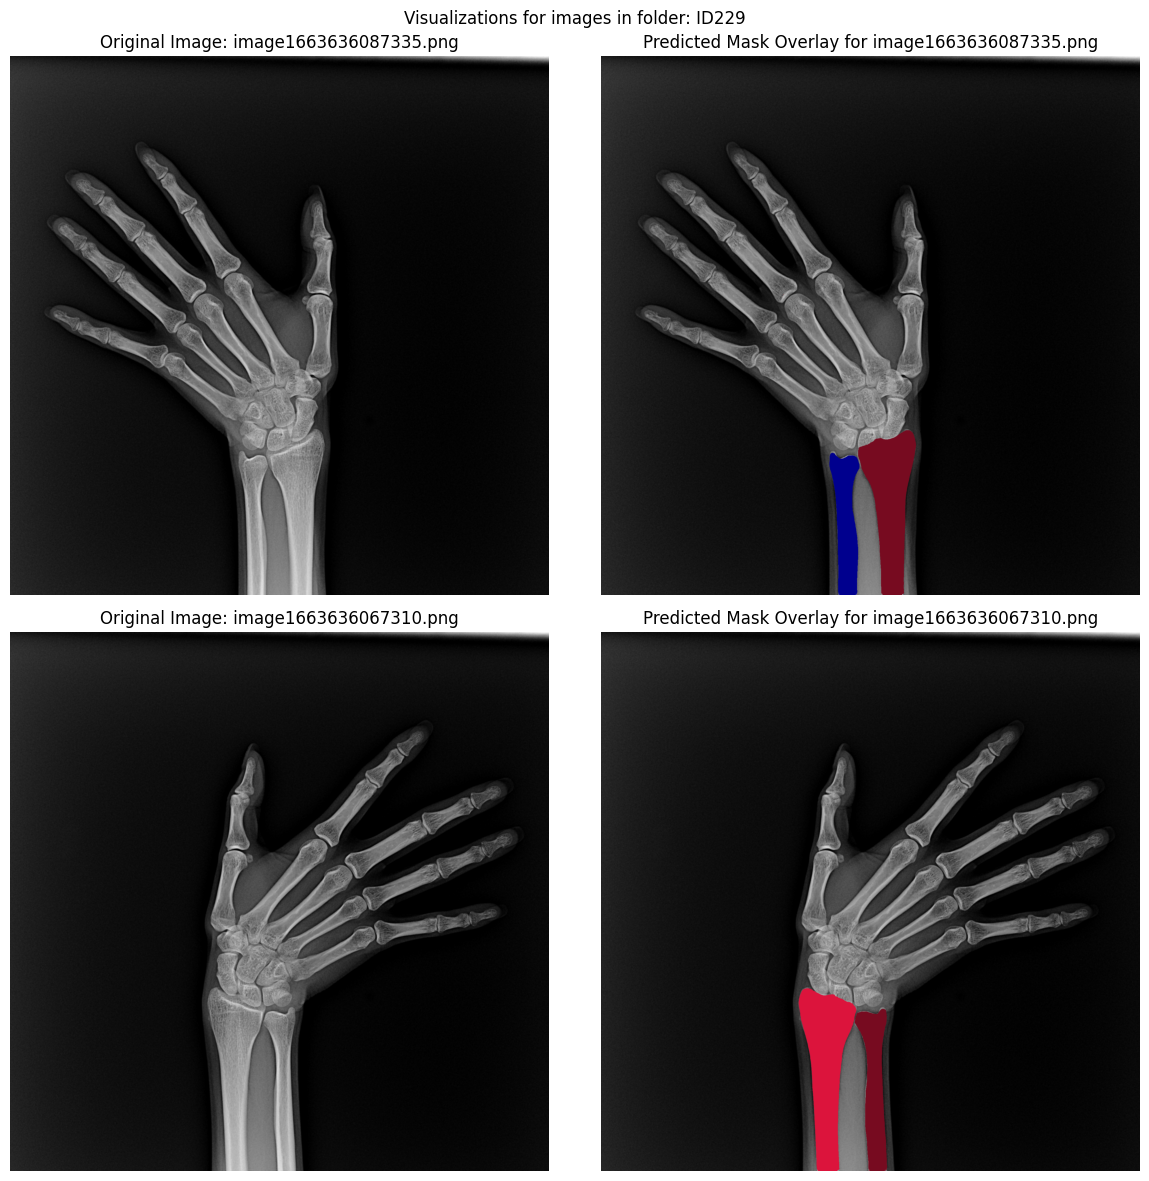

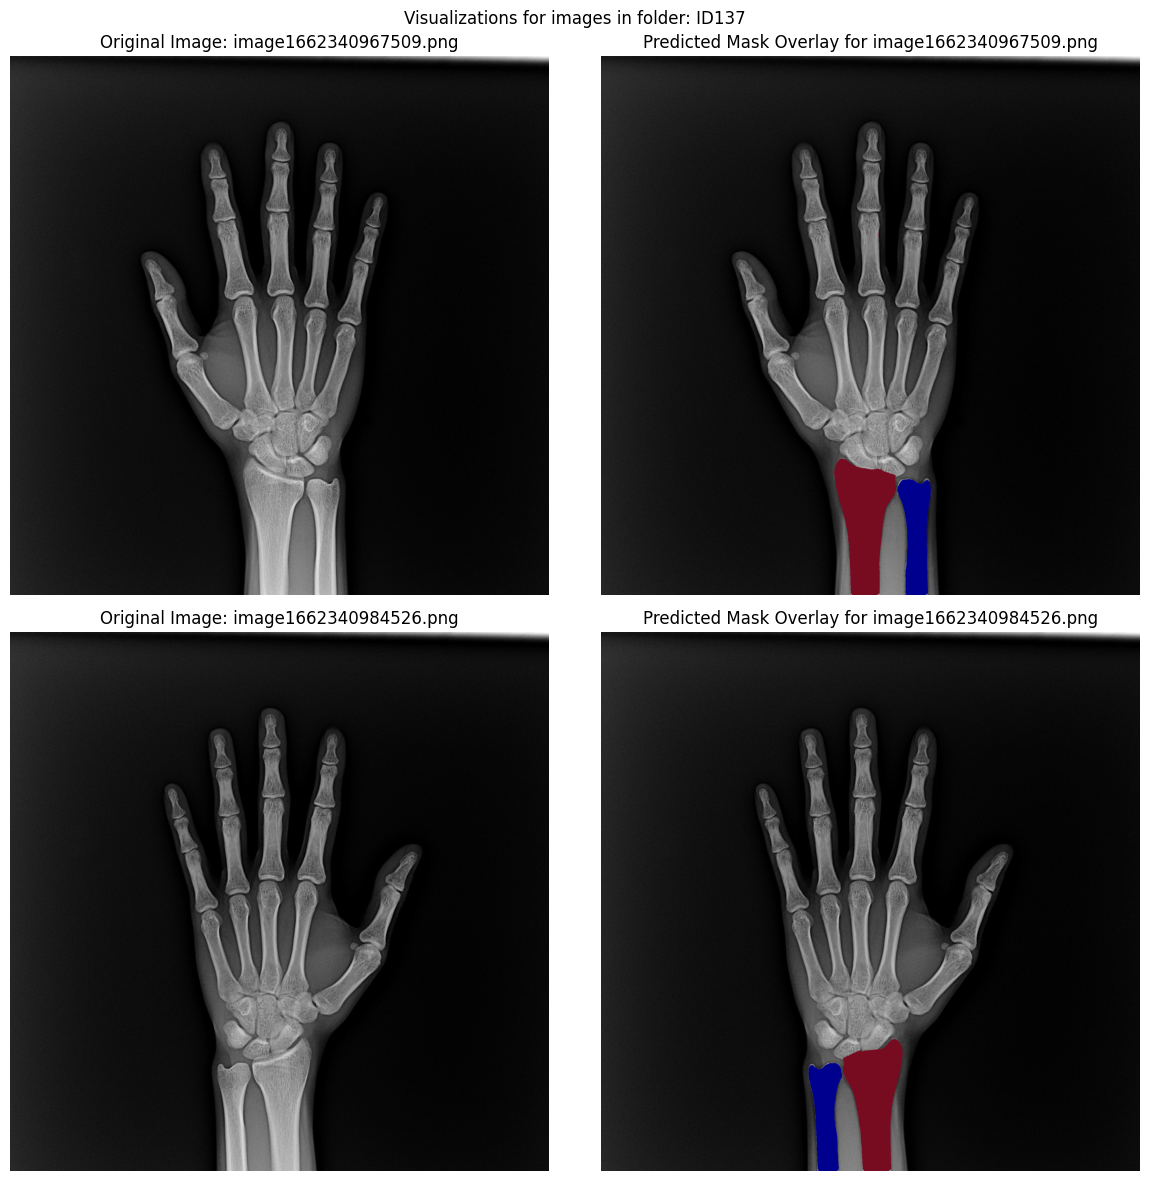

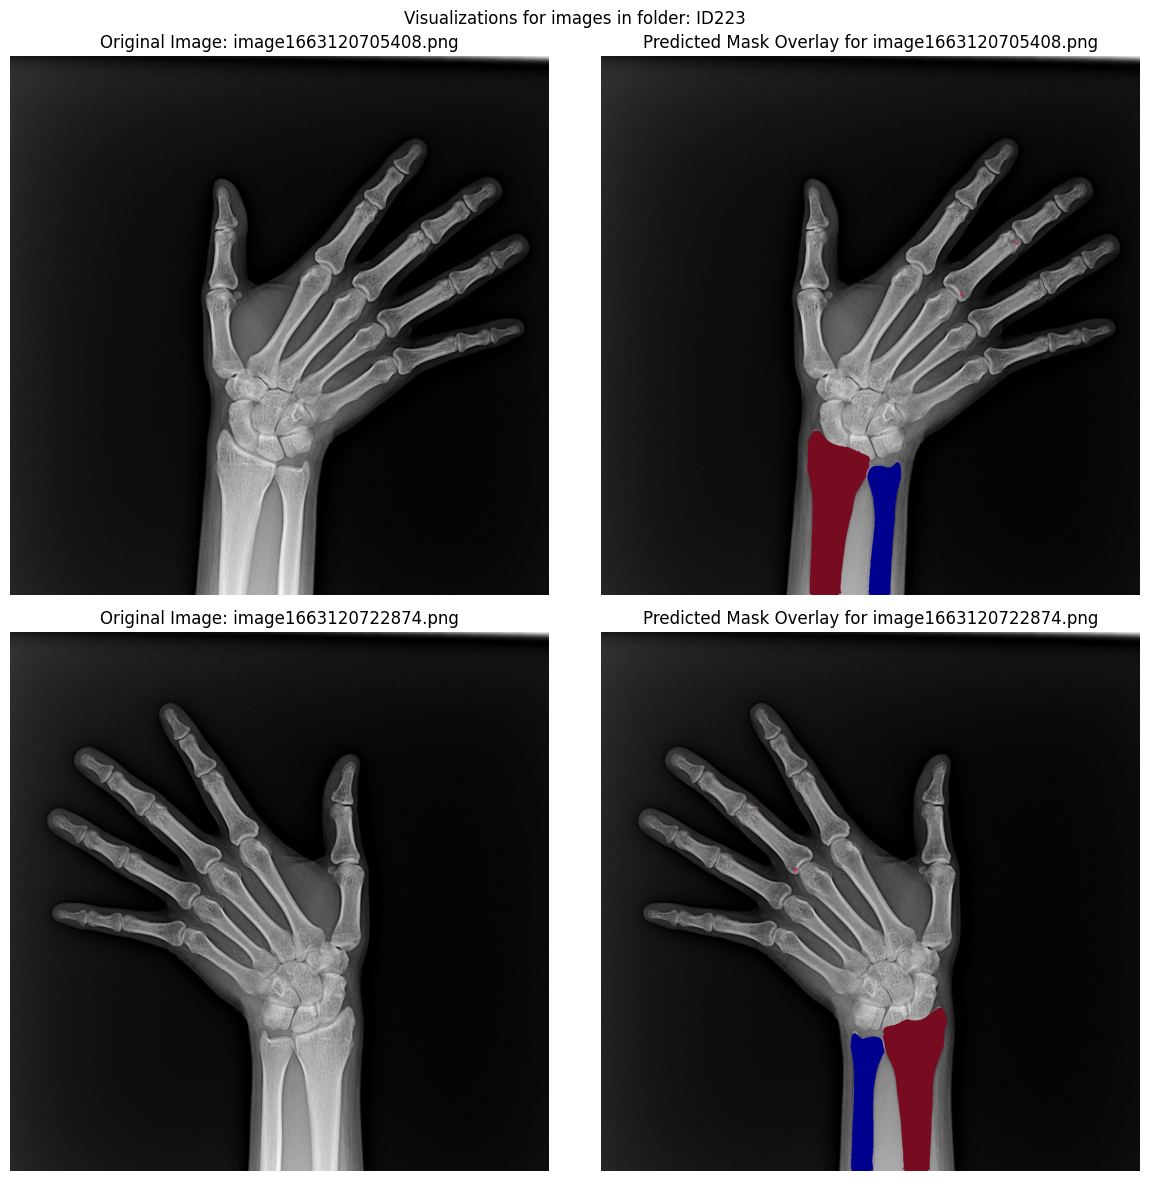

In [9]:
# Visualize할 이미지 IND2IMG에서 랜덤하게 10개의 키(IND) 추출
visualize_id = random.sample(list(ID2IMG.keys()), min(10, len(ID2IMG)))
# visualize_id = ['ID040']  # <- 특정 이미지만 plot하고 싶을 때

visualize_segmentation(df, visualize_id)